In [36]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [37]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [38]:
model = "deepseek-r1-distill-llama-70b"

In [39]:
from langchain_groq import ChatGroq

In [40]:
llm = ChatGroq(model=model)

In [41]:
llm.invoke("Hey, what's the weather like in SF?")

AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.202658835, 'prompt_time': 0.000408616, 'queue_time': 0.219712921, 'total_time': 0.203067451}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--a2ed6890-dab1-47a9-9fdd-f2de07443230-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})

In [42]:
import operator
from typing import List
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import END, StateGraph, MessagesState, START
from pydantic import BaseModel, Field

In [43]:
def call_model(state):
    message = state["messages"]
    response = llm.invoke(message)
    return {"messages": [response]}

In [44]:
state = {"messages":["Hey, what's the weather like in SF?"]}

In [45]:
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.236127529, 'prompt_time': 0.000405476, 'queue_time': 0.21980159600000002, 'total_time': 0.236533005}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--40164003-45ee-4ef9-9ad6-fb551aefae6c-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}

In [46]:
workflow = StateGraph(MessagesState)

In [47]:
workflow.add_node("mybot", call_model)
workflow.add_edge(START, "mybot")

In [48]:
workflow.add_edge("mybot",END)

In [49]:
app = workflow.compile()

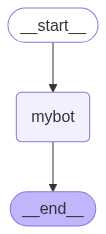

In [50]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [51]:
input = {"messages": ["Hey, what's the weather like in SF?"]}

In [52]:
app.invoke(input)

{'messages': [HumanMessage(content="Hey, what's the weather like in SF?", additional_kwargs={}, response_metadata={}, id='b3ab9c6f-1a90-4f9e-815c-1ea459a6b7eb'),
  AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.232519023, 'prompt_time': 0.000892402, 'queue_time': 0.22702588, 'total_time': 0.233411425}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--fd5c025d-64e8-4c69-b2fa-924940f27bc9-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}

In [53]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"{key}: {value}")

mybot: {'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.223406419, 'prompt_time': 0.000407986, 'queue_time': 0.220392116, 'total_time': 0.223814405}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--8c5fa9c1-23f5-4868-86ca-bcd6d5cd7f32-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}


In [54]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """Searches the web for a query and returns the top result."""
    if "mumbai" in query.lower():
        return "Temperature in Mumbai is 30°C with high humidity."
    
    return "IDK"

In [55]:
search.invoke("What is the temperature in Kashmir?")

'IDK'

In [56]:
search.invoke("What is the temperature in Mumbai?")

'Temperature in Mumbai is 30°C with high humidity.'

In [57]:
tools = [search]
llm_with_tool = llm.bind_tools(tools)

In [58]:
response = llm_with_tool.invoke("What is the temperature in Mumbai?")

In [59]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'Mumbai temperature'},
  'id': 'zat9aeth0',
  'type': 'tool_call'}]

In [60]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [61]:
call_model(input)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qf4rfhd7j', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 138, 'total_tokens': 243, 'completion_time': 0.519193561, 'prompt_time': 0.015329041, 'queue_time': 0.21980751, 'total_time': 0.534522602}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1cd2154c-738b-478d-af53-2aecb64aab22-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'qf4rfhd7j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 138, 'output_tokens': 105, 'total_tokens': 243})]}

In [62]:
def router_function(state:MessagesState):
    message = state["messages"]
    last_message = message[-1]
    
    if last_message.tool_calls:
        return "tools"
    return END

In [63]:
from langgraph.prebuilt import ToolNode

In [64]:
tool_node = ToolNode(tools)

In [ ]:
workflow2 = StateGraph(MessagesState)
workflow2.add_node("llmwithnode",call_model)
workflow2.add_node("mytools",tool_node)

In [ ]:
workflow2.add_edge(START,"llmwithnode")

workflow2.add_conditional_edges("llmwithnode", router_function, {
    "tools": "mytools",
    END: END
})

In [67]:
app2 = workflow2.compile()

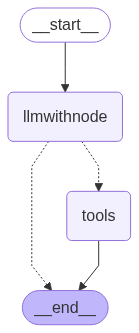

In [68]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [69]:
app2.invoke({"messages":["What is the temperature in Mumbai?"]})

{'messages': [HumanMessage(content='What is the temperature in Mumbai?', additional_kwargs={}, response_metadata={}, id='1ebe01f5-8a80-4ed0-bbe1-9373c27daf8f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gb7ksrd3w', 'function': {'arguments': '{"query":"temperature in Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 135, 'total_tokens': 259, 'completion_time': 0.499182192, 'prompt_time': 0.015226801, 'queue_time': 0.21973351, 'total_time': 0.514408993}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4f7748bb-cbe3-4660-8833-efdf5a4cd24c-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Mumbai'}, 'id': 'gb7ksrd3w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 124, 'total_tokens': 259}),
  ToolMessage(content='Temperature in Mumbai is 30°C 

In [70]:
app2.invoke({"messages":["What is the temperature in Delhi?"]})

{'messages': [HumanMessage(content='What is the temperature in Delhi?', additional_kwargs={}, response_metadata={}, id='1db1e2b4-bbc0-4927-9796-cfad74942df5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hv1ab0f58', 'function': {'arguments': '{"query":"temperature in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 135, 'total_tokens': 227, 'completion_time': 0.684853235, 'prompt_time': 0.015228813, 'queue_time': 0.230607485, 'total_time': 0.700082048}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--427d3885-3f29-42fd-8862-ae5607a09840-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Delhi'}, 'id': 'hv1ab0f58', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 92, 'total_tokens': 227}),
  ToolMessage(content='IDK', name='search', id='60b47167-